In [275]:
# New Confidence Bound Algorihm

import numpy as np
import math

class NewConfidenceBound:
    def __init__(self, mab, period, max_steps):
        self.mab = mab
        self.num_arms = mab.num_arms
        self.max_steps = max_steps
        self.period = period
        self.Q_a = np.zeros(self.num_arms)
        self.N_a = np.zeros(self.num_arms)
        self.fourier_coefficients = np.zeros((self.num_arms, 3))  # a0, a1, b1 for each arm
        self.total_reward = 0
        self.reward_t = np.zeros(max_steps)
        self.observed_times = [[] for _ in range(self.num_arms)]  # Initialize as lists of lists
        self.observed_rewards = [[] for _ in range(self.num_arms)]

    def run(self, max_steps, debug=False):
        num_steps = 0
        while num_steps < max_steps:  # Assuming a maximum of 10,000 steps
            arm_to_pull = self.select_action(num_steps)
            current_reward = self.mab.pull_arm(arm_to_pull, num_steps)
            self.total_reward += current_reward
            self.reward_t[num_steps] = current_reward
            if(debug):
                print(f'Current reward: {self.total_reward}')
            self.N_a[arm_to_pull] += 1
            self.Q_a[arm_to_pull] = self.Q_a[arm_to_pull] + \
                (1 / self.N_a[arm_to_pull]) * \
                (current_reward - self.Q_a[arm_to_pull])
            self.update_fourier_coefficients(arm_to_pull, current_reward, num_steps)
            num_steps += 1
        return self.reward_t, self.total_reward

    def select_action(self, t):
        predicted_rewards = []
        for arm in range(self.num_arms):
            a0, a1, b1 = self.fourier_coefficients[arm]
            predicted_reward = a0 + a1 * np.cos(2 * np.pi * t / self.period) + b1 * np.sin(2 * np.pi * t / self.period)
            predicted_rewards.append(predicted_reward)
        arm_to_pull = np.argmax(predicted_rewards)
        return arm_to_pull

    def update_fourier_coefficients(self, arm, reward, t):
        # Assuming self.fourier_coefficients is already initialized in the class constructor
        # and is intended to store the Fourier coefficients for each arm.
        
        # Check if this is the first time updating coefficients for this arm
        if self.N_a[arm] == 1:
            # Initialize lists to store times and rewards for the arm
            self.observed_times[arm] = [t]
            self.observed_rewards[arm] = [reward]
        else:
            # Append the new time and reward to the lists for the arm
            self.observed_times[arm].append(t)
            self.observed_rewards[arm].append(reward)

        # Convert observed times and rewards for the arm into numpy arrays for calculation
        times = np.array(self.observed_times[arm])
        rewards = np.array(self.observed_rewards[arm])

        # Normalize times by the period to bring them within a single period cycle
        normalized_times = 2 * np.pi * (times % self.period) / self.period

        # Calculate Fourier coefficients
        # a0: Average of the rewards (DC component)
        a0 = np.mean(rewards)

        # a1: Cosine coefficient
        a1 = (2 / len(times)) * np.sum(rewards * np.cos(normalized_times))

        # b1: Sine coefficient
        b1 = (2 / len(times)) * np.sum(rewards * np.sin(normalized_times))

        # Update the Fourier coefficients for the arm
        self.fourier_coefficients[arm] = [a0, a1, b1]
    
    def getParameters(self):
        return self.Q_a, self.N_a, self.total_reward, self.reward_t, self.observed_times, self.observed_rewards

    # Clear vars
    def clear(self):
        self.Q_a = np.zeros(self.num_arms)
        self.N_a = np.zeros(self.num_arms)
        self.T_a = np.ones(self.num_arms)
        self.total_reward = 0
        self.reward_t = np.zeros(self.max_steps)
        self.observed_times = [[] for _ in range(self.num_arms)]
        self.observed_rewards = [[] for _ in range(self.num_arms)]



In [204]:
# Upper Confidence Bound Algorithm

import numpy as np
import math


class UpperConfidenceBound:
    def __init__(self, c, mab, max_steps):
        self.mab = mab
        self.max_steps = max_steps
        self.num_arms = mab.num_arms
        self.Q_a = np.zeros(self.num_arms)
        self.N_a = np.zeros(self.num_arms)
        self.total_reward = 0
        self.observed_times = [[] for _ in range(self.num_arms)]
        self.observed_rewards = [[] for _ in range(self.num_arms)]
        self.c = c

    def run(self, max_steps, debug=False):
        # Store reward at each t
        self.reward_t = np.zeros(self.max_steps)
        # pull each arm once
        for i in range(self.num_arms):
            current_reward = self.mab.pull_arm(i, i)
            self.total_reward += current_reward
            self.reward_t[i] = current_reward
            self.N_a[i] += 1
            self.Q_a[i] = self.Q_a[i] + \
                (1 / self.N_a[i]) * \
                (current_reward - self.Q_a[i])

        num_steps = 1
        while(num_steps < max_steps):
            arm_to_pull = self.select_action(num_steps)
            current_reward = self.mab.pull_arm(
                arm_to_pull, num_steps)
            self.total_reward += current_reward
            self.reward_t[num_steps] = current_reward
            if(debug):
                print(f'Current reward : {self.total_reward}')
            self.observed_times[arm_to_pull].append(num_steps)
            self.observed_rewards[arm_to_pull].append(current_reward)
            self.N_a[arm_to_pull] += 1
            self.Q_a[arm_to_pull] = self.Q_a[arm_to_pull] + \
                (1 / self.N_a[arm_to_pull]) * \
                (current_reward - self.Q_a[arm_to_pull])
            num_steps += 1
        return self.reward_t, self.total_reward

    def select_action(self, t):
        # Estimate upper bound and choose action with largest estimated upper bound
        arm_to_pull = np.argmax(
            self.Q_a+self.c*np.sqrt(math.log(t)/self.N_a))
        return arm_to_pull

    def getParameters(self):
        return self.Q_a, self.N_a, self.total_reward, self.reward_t, self.observed_times, self.observed_rewards

    # Clear vars
    def clear(self):
        self.Q_a = np.zeros(self.num_arms)
        self.N_a = np.zeros(self.num_arms)
        self.total_reward = 0
        self.reward_t = np.zeros(self.max_steps)
        self.observed_times = [[] for _ in range(self.num_arms)]
        self.observed_rewards = [[] for _ in range(self.num_arms)]



In [205]:
# EGreedy Algorithm

import numpy as np


class Egreedy:
    def __init__(self, eps, mab):
        self.mab = mab
        self.num_arms = mab.num_arms
        self.Q_a = np.zeros(self.num_arms)
        self.N_a = np.zeros(self.num_arms)
        self.total_reward = 0
        self.observed_times = [[] for _ in range(self.num_arms)]
        self.observed_rewards = [[] for _ in range(self.num_arms)]
        self.eps = eps

    def run(self, max_steps, debug=False):
        # Store reward at each t
        self.reward_t = np.zeros(max_steps)
        num_steps = 1
        while(num_steps < max_steps):
            arm_to_pull = self.select_action(self.eps)
            current_reward = self.mab.pull_arm(
                arm_to_pull, num_steps)
            self.total_reward += current_reward
            self.reward_t[num_steps] = current_reward
            if(debug):
                print(f'Current reward : {self.total_reward}')
            self.observed_times[arm_to_pull].append(num_steps)
            self.observed_rewards[arm_to_pull].append(current_reward)
            self.N_a[arm_to_pull] += 1
            self.Q_a[arm_to_pull] = self.Q_a[arm_to_pull] + \
                (1 / self.N_a[arm_to_pull]) * \
                (current_reward - self.Q_a[arm_to_pull])
            num_steps += 1
        return self.reward_t, self.total_reward

    def select_action(self, eps):
        s = np.random.uniform(0, 1)
        # Exploit
        if(s > eps):
            # Arm with highest reward
            arm_to_pull = np.argmax(self.Q_a)
        # Explore
        else:
            # Random arm choosen
            arm_to_pull = np.random.randint(
                low=0, high=self.mab.num_arms)
        return arm_to_pull

    def getParameters(self):
        return self.Q_a, self.N_a, self.total_reward, self.reward_t, self.observed_times, self.observed_rewards

    # Clear vars
    def clear(self):
        self.Q_a = np.zeros(self.num_arms)
        self.N_a = np.zeros(self.num_arms)
        self.total_reward = 0
        self.observed_times = [[] for _ in range(self.num_arms)]
        self.observed_rewards = [[] for _ in range(self.num_arms)]


In [206]:
# Greedy Algorithm

import numpy as np


class Greedy:
    def __init__(self, Q1, mab):
        self.Q1 = Q1
        self.mab = mab
        self.num_arms = mab.num_arms
        self.Q_a = np.full((self.num_arms), self.Q1)
        self.N_a = np.zeros(self.num_arms)
        self.total_reward = 0
        self.observed_times = [[] for _ in range(self.num_arms)]
        self.observed_rewards = [[] for _ in range(self.num_arms)]

    def run(self, max_steps, debug=False):
        # Store reward at each t
        self.reward_t = np.zeros(max_steps)
        num_steps = 1
        while(num_steps < max_steps):
            arm_to_pull = self.select_action()
            current_reward = self.mab.pull_arm(
                arm_to_pull, num_steps)
            self.total_reward += current_reward
            self.reward_t[num_steps] = current_reward
            if(debug):
                print(f'Current reward : {self.total_reward}')
            self.observed_times[arm_to_pull].append(num_steps)
            self.observed_rewards[arm_to_pull].append(current_reward)
            self.N_a[arm_to_pull] += 1
            self.Q_a[arm_to_pull] = self.Q_a[arm_to_pull] + \
                (1 / self.N_a[arm_to_pull]) * \
                (current_reward - self.Q_a[arm_to_pull])
            num_steps += 1
        return self.reward_t, self.total_reward

    def select_action(self):
        # Exploit
        # Arm with highest reward
        arm_to_pull = np.argmax(self.Q_a)
        return arm_to_pull

    def getParameters(self):
        return self.Q_a, self.N_a, self.total_reward, self.reward_t, self.observed_times, self.observed_rewards

    # Clear vars
    def clear(self):
        self.Q_a = np.full((self.num_arms), self.Q1)
        self.N_a = np.zeros(self.num_arms)
        self.total_reward = 0
        self.observed_times = [[] for _ in range(self.num_arms)]
        self.observed_rewards = [[] for _ in range(self.num_arms)]


In [207]:
# Thompson Sampling Algorithm

import numpy as np
import math

class ThompsonSampling:
    def __init__(self, maxSteps, mab):
        self.maxSteps = maxSteps
        self.mab = mab
        self.num_arms = mab.num_arms
        self.alpha = np.ones(self.num_arms)
        self.beta = np.ones(self.num_arms)
        self.Q_a = np.zeros(self.num_arms)
        self.N_a = np.zeros(self.num_arms)
        self.total_reward = 0
        self.reward_t = np.zeros(self.maxSteps)
        self.observed_times = [[] for _ in range(self.num_arms)]
        self.observed_rewards = [[] for _ in range(self.num_arms)]
    
    def run(self, maxSteps, debug=False):
        for t in range(maxSteps):
            # Step 1: Sample from the posterior for each arm
            sampled_theta = np.random.beta(self.alpha, self.beta)
            
            # Step 2: Select the arm with the highest sampled value
            arm_selected = self.select_action(sampled_theta)
            
            # Step 3: Pull the selected arm and observe the reward
            reward = self.mab.pull_arm(arm_selected, t)
            self.total_reward += reward
            self.reward_t[t] = reward
            
            # Step 4: Update the posterior distribution for the selected arm
            if reward > 0:
                self.alpha[arm_selected] += 1
            else:
                self.beta[arm_selected] += 1
            
            # Optional: Store observed times and rewards for analysis
            self.observed_times[arm_selected].append(t)
            self.observed_rewards[arm_selected].append(reward)
            
            if debug:
                print(f"Step {t+1}: Arm {arm_selected} selected, reward: {reward}")
            
        return self.reward_t, self.total_reward
    
    def select_action(self, sampled_theta):
        arm_selected = np.argmax(sampled_theta)
        return arm_selected
    
    def getParameters(self):
        return self.Q_a, self.N_a, self.total_reward, self.reward_t, self.observed_times, self.observed_rewards

    # Clear vars
    def clear(self):
        self.alpha = np.ones(self.num_arms)
        self.beta = np.ones(self.num_arms)
        self.Q_a = np.zeros(self.num_arms)
        self.N_a = np.zeros(self.num_arms)
        self.total_reward = 0
        self.reward_t = np.zeros(self.maxSteps)
        self.observed_times = [[] for _ in range(self.num_arms)]
        self.observed_rewards = [[] for _ in range(self.num_arms)]




In [227]:
# Optimal Algorithm

import numpy as np

class OptimalAlgorithm:
    def __init__(self, optimalArm, maxSteps, mab):
        self.optimalArm = optimalArm
        self.mab = mab
        self.maxSteps = maxSteps
        self.total_reward = 0
        self.reward_t = np.zeros(self.maxSteps)
        self.Q_a = np.zeros(1)
        self.N_a = np.zeros(1)
        self.observed_times = [[]]
        self.observed_rewards = [[]]
    
    def run(self, maxSteps, debug=False):
        for t in range(maxSteps):
            # Pull the optimal arm and observe the reward
            reward = self.mab.pull_arm(self.optimalArm, t)
            self.total_reward += reward
            self.reward_t[t] = reward
            self.N_a[0] += 1
            self.Q_a[0] = self.Q_a[0] + (1 / self.N_a[0]) * (reward - self.Q_a[0])
            
            # Optional: Store observed times and rewards for analysis
            self.observed_times[0].append(t)
            self.observed_rewards[0].append(reward)
            
            if debug:
                print(f"Step {t+1}: Reward: {reward}")
        
        return self.reward_t, self.total_reward

    def getParameters(self):
        return self.Q_a, self.N_a, self.total_reward, self.reward_t, self.observed_times, self.observed_rewards
    
    # Clear vars
    def clear(self):
        self.total_reward = 0
        self.reward_t = np.zeros(self.maxSteps)
        self.Q_a = np.zeros(1)
        self.N_a = np.zeros(1)
        self.observed_times = [[]]
        self.observed_rewards = [[]]

In [276]:
# MAB Constructor

import numpy as np
import math


class MultiArmBandit:
    def __init__(self, num_arms, period, optimalArm, debug=False):
        self.num_arms = num_arms
        self.possible_actions = np.zeros(num_arms)
        self.period = period
        self.q_a = np.zeros(num_arms)
        self.optimalArm = optimalArm

        # Ini mean values
        for i in np.arange(num_arms):
            self.q_a[i] = np.random.normal(loc=0, scale=math.sqrt(1))

    def pull_arm(self, index_arm, t, debug=False):
        T = self.period
        # Adjust phase shift and amplitude based on arm index for variability
        phase_shift = index_arm * (2 * np.pi / self.num_arms)
        amplitude = 1 #+ 0.5 * np.sin(2 * np.pi * index_arm / self.num_arms)
        noise = np.random.normal(loc=0, scale=0.1)  # Consider experimenting with the scale

        if (index_arm == self.optimalArm):
            r_t = amplitude * np.sin((2 * np.pi / T) * t + phase_shift)
            r_t = abs(r_t)
        elif index_arm % 2 == 0:
            r_t = amplitude * np.cos((2 * np.pi / T) * t)
            r_t = -abs(r_t)
        else:
            r_t = 0.5 * np.sin((2 * np.pi / T) * t)
            r_t = -abs(r_t)
        
        r_t += noise

        return r_t

    def print_actions(self):
        print(f'Possible actions - {self.possible_actions}')


In [246]:
# Experiment Runner

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class ExperimentRunner:
    def __init__(self, num_runs, max_steps, optimalAlgName):
        self.all_results_part1 = pd.DataFrame()
        self.all_results_part2 = pd.DataFrame()
        self.num_runs = num_runs
        self.max_steps = max_steps
        self.optimalAlgName = optimalAlgName

    def runExperiments_part1(self, alg, alg_name=""):
        results_t_list = pd.DataFrame()
        for i in np.arange(self.num_runs):
            results_t, total_results = alg.run(self.max_steps)
            results_t_list = pd.concat(
                [results_t_list, pd.DataFrame(results_t)], axis=1)
            alg.clear()
        mean_per_timestep = results_t_list.mean(axis=1)
        mean_per_timestep = mean_per_timestep.reset_index().T.drop('index')
        mean_per_timestep['alg_name'] = alg_name
        mean_per_timestep = mean_per_timestep.set_index('alg_name')
        self.all_results_part1 = pd.concat(
            [self.all_results_part1, pd.DataFrame(mean_per_timestep)], axis=0)

        

    def plot_part1(self):
        ax = self.all_results_part1.T.plot()
        ax.set_ylabel(f'Average reward over {self.num_runs} runs')
        ax.set_xlabel(f'Steps')
        plt.show()

    def plotInstantaneousRegret(self):
        #subtract each algorithm with optimal to find the regret
        regret = pd.DataFrame()
        for i in range(len(self.all_results_part1)):
            if self.all_results_part1.index[i] == self.optimalAlgName:
                continue
            regret[self.all_results_part1.index[i]] = self.all_results_part1.loc[self.optimalAlgName] - self.all_results_part1.iloc[i]
        ax = regret.plot()
        ax.set_ylabel(f'Instantaneous Regret')
        ax.set_xlabel(f'Steps')
        plt.show()

    def plotCumulativeRegret(self):
        regret = pd.DataFrame()
        for i in range(len(self.all_results_part1)):
            if self.all_results_part1.index[i] == self.optimalAlgName:
                continue
            regret[self.all_results_part1.index[i]] = self.all_results_part1.loc[self.optimalAlgName] - self.all_results_part1.iloc[i]
            regret[self.all_results_part1.index[i]] = regret[self.all_results_part1.index[i]].cumsum()
        ax = regret.plot()
        ax.set_ylabel(f'Cumulative Regret')
        ax.set_xlabel(f'Steps')
        plt.show()


    def runExperiments_part2(self, algs, exp_range, max_steps=1000,  alg_name=""):
        self.max_steps = max_steps
        results_list = []
        all_mean_value_per_alg = []
        for alg_impl in algs:
            results_t, total_results = alg_impl.run(max_steps)
            mean_per_alg = results_t.mean(axis=0)
            all_mean_value_per_alg.append(mean_per_alg)
        all_mean_value_per_alg_df = pd.DataFrame(all_mean_value_per_alg)
        all_mean_value_per_alg_df.reset_index(
            inplace=True, drop=True)
        all_mean_value_per_alg_df = all_mean_value_per_alg_df.T
        all_mean_value_per_alg_df.columns = [exp_range]
        return all_mean_value_per_alg_df

    def plot_part2(self, df1, df2, df3, df4):
        plt.plot(list(
            df1.columns.get_level_values(0)), df1.values.flatten(), label="e-greedy")
        plt.plot(list(
            df2.columns.get_level_values(0)), df2.values.flatten(), label="greedy")
        plt.plot(list(
            df3.columns.get_level_values(0)), df3.values.flatten(), label="ucb")
        plt.plot(list(
            df4.columns.get_level_values(0)), df4.values.flatten(), label="ncb")
        ax = plt.gca()
        ax.set_title(
            'Summary of Results for Multi-Armed Bandit with different algorithms')
        ax.set_ylabel(f'Average reward over {self.max_steps} steps')
        ax.set_xlabel(
            f'Different Hyperparameters - (Eps-greedy : eps, Greedy : Q0, ucb: c) ')
        plt.legend()
        ax.set_xscale('log')
        plt.show()


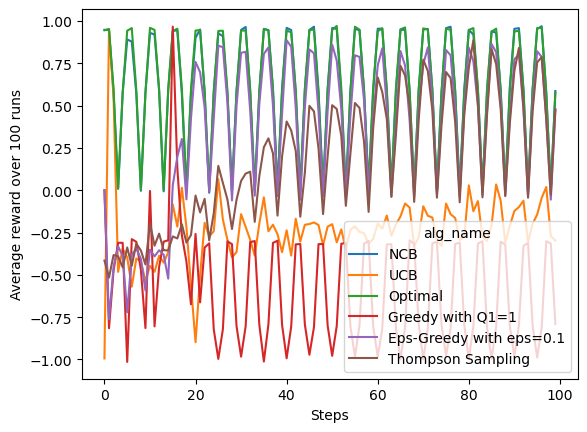

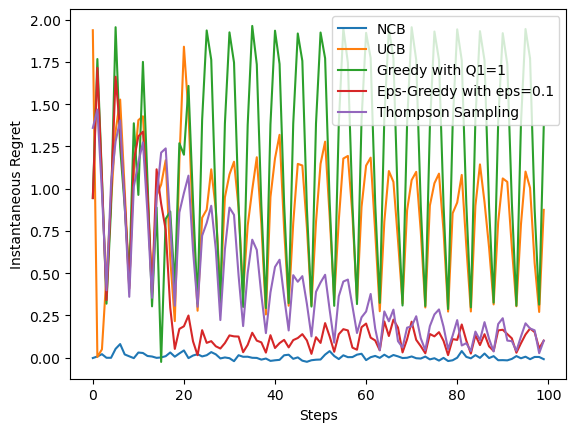

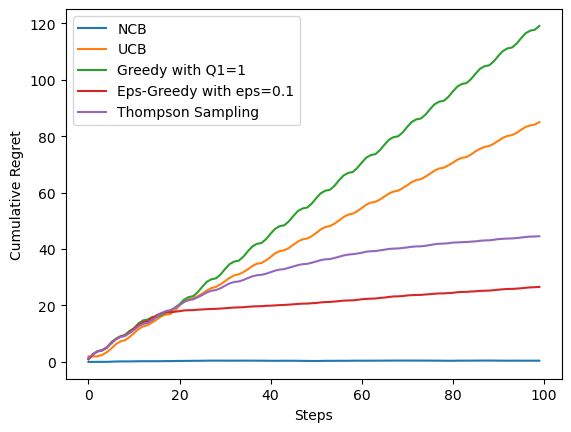

In [277]:
# Part 1 - The effect of the periodicity of the reward function on the algorithms expected rewards

import matplotlib.pyplot as plt
import numpy as np


np.random.seed(42)


numOfArms = 20
numOfRuns = 100
maxSteps = 100
optimalArm = 14
period = 10
experiment_runner = ExperimentRunner(num_runs=numOfRuns, max_steps=maxSteps, optimalAlgName='Optimal')
mab = MultiArmBandit(numOfArms, period=period, optimalArm=optimalArm)
new_bound_conf = NewConfidenceBound(mab=mab, period=period, max_steps=maxSteps)
experiment_runner.runExperiments_part1(alg=new_bound_conf, alg_name=f'NCB')
ucb_bound_conf = UpperConfidenceBound(c=2, mab=mab, max_steps=maxSteps)
experiment_runner.runExperiments_part1(alg=ucb_bound_conf, alg_name=f'UCB')
optimalArg = OptimalAlgorithm(optimalArm, maxSteps, mab=mab)
experiment_runner.runExperiments_part1(alg=optimalArg, alg_name=f'Optimal')
q1 = 1
greedy_optimistic_ini = Greedy(Q1=q1, mab=mab)
experiment_runner.runExperiments_part1(alg=greedy_optimistic_ini, alg_name=f'Greedy with Q1={q1}')
eps = 0.1
e_greedy = Egreedy(eps=eps, mab=mab)
experiment_runner.runExperiments_part1(alg=e_greedy, alg_name=f'Eps-Greedy with eps={eps}')
thompson_sampling = ThompsonSampling(maxSteps, mab)
experiment_runner.runExperiments_part1(alg=thompson_sampling, alg_name=f'Thompson Sampling')

experiment_runner.plot_part1()
experiment_runner.plotInstantaneousRegret()
experiment_runner.plotCumulativeRegret()



In [ ]:
# numArmsArray = [5, 10, 20, 50, 100]
# period = 400
# maxSteps = 1000

# # visualize the reward
# numArms = 10
# rewardArray = np.zeros((numArms, maxSteps))
# mab = MultiArmBandit(numArms, period=period)
# for i in range(numArms):
#     for t in range(maxSteps):
#         rewardArray[i][t] = mab.pull_arm(i, t)

# # plot the reward in time for each arm on the same figure
# plt.figure()
# plt.plot(rewardArray[0], label=f'Arm {0}')
# plt.plot(rewardArray[1], label=f'Arm {1}')
# plt.plot(rewardArray[2], label=f'Arm {2}')
# plt.plot(rewardArray[3], label=f'Arm {3}')
# plt.plot(rewardArray[4], label=f'Arm {4}')
# plt.plot(rewardArray[5], label=f'Arm {5}')
# plt.plot(rewardArray[6], label=f'Arm {6}')
# plt.plot(rewardArray[7], label=f'Arm {7}')
# plt.plot(rewardArray[8], label=f'Arm {8}')
# plt.plot(rewardArray[9], label=f'Arm {9}')

# plt.title('Reward function for each arm')
# plt.xlabel('Time')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()